In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib import cm

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from fluids import ATMOSPHERE_1976

import xarray as xr 
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata
from matplotlib import cm
import imageio
from IPython.display import Image
import re
#matplotlib notebook
%matplotlib widget

In [2]:
def aggregate_data(base_dir, month, day, write=False):

    """With a folder containing multiple station's worth of Radiosonde data, create a concatenated CSV of all radiosonde data from the 
    given day of the given month.\\
    
    base_dir: Directory containing all station data folders.\\
    month: integer from 1-12\\
    day: integer from 1-x, based on which month you select"""

    print('AGGREGATION... ')

    csv_list = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder+'/2023/') #Can modify this for the year

        folder_path = os.path.join(folder_path, str(month)) #create a path to the folder for the month you want data from

        if os.path.isdir(folder_path):
                #Finds every csv in the selected month folder
                csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

                if csv_files:
                    # Read the X-th (x is the day you choose) CSV file in the selected folder
                    first_csv_path = os.path.join(folder_path, csv_files[day])
                    
                    # Append the path to the list
                    csv_list.append(first_csv_path)

    df_list = []

    # Loop through the csv_list and read each CSV file
    for csv_path in csv_list:
        df = pd.read_csv(csv_path)

        #create a new column for the date and time of the reading
        datetime = csv_path.split('/')[-1].split('.')[0].split('-')[1:]
        timestep = '-'.join(datetime)
        df['TIMESTEP'] = timestep
        df_list.append(df)

    # Concatenate all the DataFrames
    concatenated_df = pd.concat(df_list, ignore_index=True).drop('Unnamed: 0', axis = 1)

    # Save the concatenated DataFrame to a new CSV file if write == True
    if write == True: 
        output_csv_path = '/path/to/save/concatenated.csv'
        concatenated_df.to_csv(output_csv_path, index=False)

    print('AGGREGATION : DONE.')
    return concatenated_df

In [3]:
def aggregate_data2(base_dir, year, month, day, hour, write=False):

    """With a folder containing multiple station's worth of Radiosonde data, create a concatenated CSV of all radiosonde data from the 
    given day of the given month.\\
    
    base_dir: Directory containing all station data folders.\\
    month: integer from 1-12\\
    day: integer from 1-x, based on which month you select"""

    print('AGGREGATION... ')

    csv_list = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder+'/' + str(year) + '/') 

        folder_path = os.path.join(folder_path, str(month)) 

        #Iterate through every station for a particular month and year (not necessarily alphabetical order)
        if os.path.isdir(folder_path):
                #Check if the station has data for that month
                csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

                if csv_files:
                    #Parse out the station info for the CSV
                    string_parse_pattern = r'^[^-]+-[^-]+-'
                    # Search the pattern in the string
                    station_info = re.match(string_parse_pattern, csv_files[0])
                    station_info = station_info.group(0)

                    #Create the correct csv string name for year, month, day, and time for that particular station
                    selected_csv  = os.path.join(folder_path, station_info + str(month) + '-' + str(day) + '-' + str(hour) + '.csv')

                    #If the CSV exists, add it to the array for parsing, otherwise skip.
                    if os.path.isfile(selected_csv):
                        # Append the path to the list
                        csv_list.append(selected_csv)

    df_list = []

    # Loop through the csv_list and read each CSV file
    for csv_path in csv_list:
        df = pd.read_csv(csv_path)

        #create a new column for the date and time of the reading
        datetime = csv_path.split('/')[-1].split('.')[0].split('-')[1:]
        timestep = '-'.join(datetime)
        df['TIMESTEP'] = timestep


        #THIS IS ALL NEW PREPROCESSING STUFF DURRING AGGREGATION

        # Drop rows where 'height' is NaN
        df = df.dropna(subset=['height'])
        # Create a new column for the rounded heights to 250m
        df['rounded_height'] = df['height'].apply(lambda x: round(x / 250) * 250)
        
        # Calculate the absolute difference between original and rounded heights
        df['abs_diff'] = abs(df['height'] - df['rounded_height'])

        # Sort by rounded height and absolute difference
        df = df.sort_values(by=['rounded_height', 'abs_diff'])

        # Drop duplicates, keeping the row with the smallest difference
        df = df.drop_duplicates(subset='rounded_height', keep='first')

        # Create a new DataFrame with the desired height intervals
        intervals = np.arange(0, 32001, 250)  # Heights from 0 to 30000 at 250m intervals
        df_intervals = pd.DataFrame({'rounded_height': intervals})

        # Merge the rounded DataFrame with the new intervals
        df_resampled = df_resampled = pd.merge(df_intervals, df, on='rounded_height', how='left')

        df_resampled['height'] = df_resampled['rounded_height']
        df_resampled = df_resampled.drop(columns=['rounded_height', 'abs_diff'])

        df_list.append(df_resampled)

    # Concatenate all the DataFrames
    concatenated_df = pd.concat(df_list, ignore_index=True).drop('Unnamed: 0', axis = 1)

    # Save the concatenated DataFrame to a new CSV file if write == True
    if write == True: 
        output_csv_path = '/path/to/save/concatenated.csv'
        concatenated_df.to_csv(output_csv_path, index=False)

    print('AGGREGATION : DONE.')
    return concatenated_df


In [4]:
def plot_level_original(df, altitude):
    
    df= df[(df['height'] >=  altitude-125)& (df['height'] <= altitude+125)]

    x = df['longitude'].values
    y = df['latitude'].values
    z = df['height'].values
    u = df['u_wind'].values
    v = df['v_wind'].values
    w = np.zeros_like(u)
    speed= df['speed']#.astype('int')
    
    norm = plt.Normalize(speed.min(), speed.max())
    colors = cm.hsv(norm(speed))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection = '3d')
    mappable = cm.ScalarMappable(cmap=cm.hsv, norm=norm)
    mappable.set_array(speed)
    cbar = plt.colorbar(mappable, ax=ax, fraction = 0.03, pad=0.1)
    cbar.set_label('Wind Speed')
    
    for i in range(len(x)):
        ax.quiver(x[i], y[i], z[i], u[i], v[i], w[i], colors=colors[i], length=2, arrow_length_ratio=0.5, normalize=True)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Pressure Level')
    plt.tight_layout
    plt.show()

In [5]:
def create_synthetic_stations(df, lat_min, lat_max, lon_min, lon_max, step, alt_step=250):

    """Use: Create a (optionally) high resolution 3-D grid of radiosonde data within a specific longitude-latitude and altitude range, 
    provided you have prior data to synthesize from.\\
    
    df: Dataframe produced by aggregate_data function, based on existing radiosonde data.\\
    lat_min: minimum latitude of region determined by df.\\
    lat_max: maximum latitude of region determined by df.\\
    lon_min: minimum longitude of region determined by df.\\
    lon_max: maximum longitude of region determined by df.\\
    step: resolution in latitude-longitude for which to generate data. (Ex. step = 1 means data will be generated each 1 lat-lon degrees).\\
    alt_step: Vertical resolution in meters for which to generate data. (Ex. alt_step = 250 means data will be generated every 250 meters.)
    """

    print('SYNTHESIZING...')

    #Creates a range of lats/lons used for coordiantes when making data.
    latitudes = np.arange(lat_min, lat_max + step, step) 
    longitudes = np.arange(lon_min, lon_max + step, step)
    
    # Define altitude range based on the min and max altitudes in the original data
    alt_min, alt_max = df['height'].min(), df['height'].max()
    altitudes = np.arange(alt_min, alt_max + alt_step, alt_step)
    
    synthetic_data = []

    station_number = 0 

    for lat in latitudes:
        for lon in longitudes:
            station_number += 1
            # Interpolate data for each altitude level
            for altitude in altitudes:
                #Collect data into layers based on alt_step distance. 
                df_alt = df[(df['height'] >= altitude - alt_step/2) & (df['height'] < altitude + alt_step/2)]
                if df_alt.empty:
                    continue
                
                #Collect all features corresponding to selected lat/lon ranges. 
                points = df_alt[['latitude', 'longitude']].values
                columns = ['pressure','height','temperature','direction','speed','u_wind','v_wind']
                
                interpolated_values = {}
                for column in columns:
                    values = df_alt[column].values
                    #Utilize Nearest neighbor interpolation to fill empty spaces on 3d grid. 
                    interpolated_values[column] = griddata(points, values, (lat, lon), method='nearest')

                synthetic_data.append({
                    **interpolated_values,
                    'station_number': station_number,
                    'latitude': lat,
                    'longitude': lon,
                    'height': altitude
                })
    
    synthetic_df = pd.DataFrame(synthetic_data)
    print('SYNTHESIS : DONE.')
    return synthetic_df

In [6]:
def create_synthetic_stations2(df, lat_min, lat_max, lon_min, lon_max, step, alt_step=250):

    """Use: Create a (optionally) high resolution 3-D grid of radiosonde data within a specific longitude-latitude and altitude range, 
    provided you have prior data to synthesize from.\\
    
    df: Dataframe produced by aggregate_data function, based on existing radiosonde data.\\
    lat_min: minimum latitude of region determined by df.\\
    lat_max: maximum latitude of region determined by df.\\
    lon_min: minimum longitude of region determined by df.\\
    lon_max: maximum longitude of region determined by df.\\
    step: resolution in latitude-longitude for which to generate data. (Ex. step = 1 means data will be generated each 1 lat-lon degrees).\\
    alt_step: Vertical resolution in meters for which to generate data. (Ex. alt_step = 250 means data will be generated every 250 meters.)
    """

    print('SYNTHESIZING...')

    #Creates a range of lats/lons used for coordiantes when making data.
    latitudes = np.arange(lat_min, lat_max + step, step) 
    longitudes = np.arange(lon_min, lon_max + step, step)
    lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

    print(latitudes)

    print(lat_grid.shape)
    print(lon_grid.shape)
    #asdasd
    
    # Define altitude range based on the min and max altitudes in the original data
    alt_min, alt_max = df['height'].min(), df['height'].max()
    altitudes = np.arange(alt_min, alt_max + alt_step, alt_step)
    
    synthetic_data = []

    station_number = 0 


    for altitude in altitudes:
        #Collect data into layers based on alt_step distance. 
        df_alt = df[(df['height'] == altitude)]

        #Check for missing data for interpolating at a particular altitude level
        df_alt = df_alt.dropna(subset=['u_wind'])
        
        if df_alt.empty:
            continue
        
        #Collect all features corresponding to selected lat/lon ranges. 
        points = df_alt[['latitude', 'longitude']].values
        variables = {
            'pressure': df_alt['pressure'].values,
            'height': df_alt['height'].values,
            'temperature': df_alt['temperature'].values,
            'direction': df_alt['direction'].values,
            'speed': df_alt['speed'].values,
            'u_wind': df_alt['u_wind'].values,
            'v_wind': df_alt['v_wind'].values,
        }


        #Create initial shape
        interpolated_values2 = griddata(points, variables['height'], (lat_grid, lon_grid), method='nearest')
        df_interpolated = pd.DataFrame( interpolated_values2, index=longitudes, columns=latitudes)
        df_interpolated = df_interpolated.reset_index()
        df_interpolated = df_interpolated.melt(id_vars='index', var_name='latitude', value_name='height')
        df_interpolated = df_interpolated.rename(columns={'index': 'longitude'})

        # Perform interpolation
        for var_name, values in variables.items():

            #grid_values = griddata(points, values, (lat_grid, lon_grid), method='nearest')
            interpolated_values = griddata(points, values, (lat_grid, lon_grid), method='nearest')

            # Convert grid values to DataFrame
            df_interpolated_var = pd.DataFrame( interpolated_values, index=longitudes, columns=latitudes)
            df_interpolated_var = df_interpolated_var.reset_index()
            df_interpolated_var = df_interpolated_var.melt(id_vars='index', var_name='latitude', value_name=var_name)
            df_interpolated_var = df_interpolated_var.rename(columns={'index': 'longitude'})

            df_interpolated[var_name] = df_interpolated_var[var_name]
            
            # Reorder columns
            #df_interpolated = df_interpolated[['latitude', 'longitude', 'altitude']]
            

        synthetic_data.append(df_interpolated)

    # Concatenate all the DataFrames
    concatenated_df = pd.concat(synthetic_data, ignore_index=True)

    # Sort by latitude, longitude, and altitude
    concatenated_df = concatenated_df.sort_values(by=['latitude', 'longitude', 'height']).reset_index(drop=True)


    
    print('SYNTHESIS : DONE.')
    return concatenated_df


In [7]:
def smooth(x, lats, lons, sigma):

    """Use: Helper function that will smooth a variable on a single altitude layer.\\
    x: list-like of variables needing to be smoothed.\\
    lats: latitude dimension (Number of unique latitude values in data).\\
    lons: longitude dimension (Number of unique longitude values in data).\\
    sigma: Standard deviation of guassian kernel (Higher value = more homogenous result overall)."""

    x = np.array(x).reshape((lats,lons)) #Reshape data into a matrix matching the geographic grid. 
    x1 = gaussian_filter(x, sigma=sigma) #apply smoothing across the matrix. 
    x1 = np.concatenate(x1, axis=0) #concatenate back to a numpy array for compatibility with later functions. 

    return x1

def get_dims(df):
    lats = df['latitude'].nunique()
    lons = df['longitude'].nunique()
    alts = df['height'].nunique()

    return (lats, lons, alts)


def glob_smooth(df, lats, lons, alts):

    """Use: With a synthetic dataframe produced by the create_synthetic_stations function, apply a gaussian smoothing 
    to each altitude layer and re-stack in order to produce a complete dtaframe of synthetic winds.\
    
    df: Synthetic dataframe from create_synthetic_stations.\\
    lats: Dimensions of latitude data. (Ex. Data has a latitude range of 70-110; lats = 40)\\
    lons: Dimensions of longitude data. (Ex. Same logic as latitudes)\\
    alts: Dimensions of altitude data. (Ex. Number of altitude levels in data) """
    
    print("SMOOTHING...")

    speed = []
    u = []
    v = []
    for i in range(0,alts): #For eahc altitude layer
        for j in range(0,lats*lons): #For each station in the latitude-longitude grid 
            idx = alts * j + i #Each station index
            speed.append(df['speed'][idx]) #Add data to a list for processing
            u.append(df['u_wind'][idx])
            v.append(df['v_wind'][idx])


        #Apply helper function for smoothing all desired variables. 
        speed1 = smooth(speed, lats, lons, 2)
        u1 = smooth(u, lats, lons, 2)
        v1 = smooth(v, lats, lons, 2)

        for j in range(0, lats*lons): #Re-create a dataframe based on structure of origina ldata with synthetic values. 
            idx = alts * j + i
            df.at[idx, 'speed'] = speed1[j]
            df.at[idx, 'u_wind'] = u1[j]
            df.at[idx, 'v_wind'] = v1[j]

        speed.clear() #clear lists for use in next altitude layer. 
        u.clear()
        v.clear()

    
    print('SMOOTHING : DONE.')
    return df

In [8]:
def plot_layer(df, type, height:int):
    if height not in df['height'].unique():
        raise ValueError("Invalid height value")

    if type == 'xy':
        x = df[df['height'] == height ]['longitude'].values
        y = df[df['height'] == height]['latitude'].values
        u = df[df['height'] == height]['u_wind'].values
        v = df[df['height'] == height]['v_wind'].values
        w = np.zeros_like(u)
        speed = df[df['height'] == height]['speed'].values

        '''
        u = u.astype(float)
        v = v.astype(float)
        print( u)
        speed = np.sqrt(u**2 + v**2)
        '''
        #speed = speed/1.94
        #speed = speed.astype('int')

        u = np.asarray(u.tolist())
        v = np.asarray(v.tolist())

        # Calculate directions for color mapping
        directions = np.arctan2(v, u)
        speed = np.sqrt(v**2 + u**2)/1.94

        # For Speed
        #norm = plt.Normalize(np.min(speed), np.max(speed))
        #colors = cm.hsv(norm(speed))

        # For Direction
        norm = plt.Normalize(-np.pi, np.pi)
        colors = cm.hsv(norm(directions)) #for Directions
        res = 1


        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection = '3d')


        #'''
        #Color Direction
        colormap = plt.colormaps.get_cmap('hsv')
        # colors = colormap(scaled_z)
        sm = plt.cm.ScalarMappable(cmap=colormap)
        sm.set_clim(vmin=-3.14, vmax=3.14)
        plt.colorbar(sm, ax=ax, shrink=.8, pad=.025)
        #'''

        '''
        #Color Speed
        mappable = cm.ScalarMappable(cmap=cm.hsv, norm=norm)
        mappable.set_array(speed)
        cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
        cbar.set_label('Wind Speed')
        '''

        for i in range(len(x)):
            ax.quiver(x[i], y[i], height/9.81, u[i], v[i], w[i], colors=colors[i], length=1, arrow_length_ratio=.5, normalize=True)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Height Level')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plt.title(str(df['timestep'][0]) + " - " + str(height/9.81) + "m" )

        #ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()

In [9]:
def format(synth_df, aggregate_df):
    synth_df['timestep'] = aggregate_df["TIMESTEP"].unique()[0] #All the data should already be the same timestep
    #synth_df.index = synth_df['timestep']
    #synth_df = synth_df.drop(columns=['temperature','direction','station_number'])
    pres = []
    for i in range(0, len(synth_df)):
        atm = ATMOSPHERE_1976(Z=synth_df['height'][i])
        pres.append(atm.P/100)
    synth_df['pressure'] = pres
    synth_df['u_wind'] = synth_df['u_wind']/1.94384 # knots to m/s
    synth_df['v_wind'] = synth_df['v_wind']/1.94384 # knots to m/s

    synth_df['timestep'] = synth_df['timestep'].apply(lambda x: '-'.join([f'{int(part):02d}' for part in x.split('-')]))
    synth_df['timestep'] = pd.to_datetime(synth_df['timestep'], format='%Y-%m-%d-%H')

    synth_df['height'] = synth_df['height']*9.81 #altitude to geopotential

    #synth_df = synth_df.round(2)

    #reverse altitude to match xarray structure
    synth_df = synth_df.reindex(index=synth_df.index[::-1])
    synth_df = synth_df.reset_index(drop=True)

    return synth_df
    

## Georgiy's Method of Synthesizing Data

In [ ]:
'''
base_dir = r"/mnt/d/RadioWinds/SOUNDINGS_DATA" 
df = aggregate_data(base_dir, 1, 0)
#print(df)

df = df[(df['height'] >= 15000) & (df['height'] <= 28000)] #Select desired altitude ranges
df = df.drop('station', axis=1).dropna() #Getting rid of unneeded columns
#Analytically selected lat/lon ranges
df = df[(df['longitude'] >= 90) & (df['longitude'] <= 131.3) & (df['latitude'] <= 18) &(df['latitude'] >= -12.4)]
#df = df[(df['longitude'] >= -135) & (df['longitude'] <= -100) & (df['latitude'] <= 45) &(df['latitude'] >= 15)]

lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
step = 1
synth_df = create_synthetic_stations(df, lat_min, lat_max, lon_min, lon_max, step)

#Format the SynthDF to match Xarray
synth_df = format(synth_df, df)

synth_df
'''

## Tristan's Method of Synthesizing Data

In [10]:
# Aggregate Data
base_dir = r"/mnt/d/RadioWinds/SOUNDINGS_DATA" 
df2 = aggregate_data2(base_dir, 2023, 1, 1, 0)
df2 = df2[(df2['longitude'] >= 90) & (df2['longitude'] <= 131.3) & (df2['latitude'] <= 18) &(df2['latitude'] >= -12.4)]
#print(df2)

df2 = df2[(df2['height'] >= 15000) & (df2['height'] <= 28000)] #Select desired altitude ranges

#Match the Lat/Lon Ranges of the ERA5 subset
lat_min, lat_max = -11, 16#int(df2['latitude'].min()), int(df2['latitude'].max())
lon_min, lon_max = 92, 132 #int(df2['longitude'].min()), int(df2['longitude'].max())

step = 1
synth_df2 = create_synthetic_stations2(df2, lat_min, lat_max, lon_min, lon_max, step)

#Format the SynthDF to match Xarray
synth_df2 = format(synth_df2, df2)

synth_df2

AGGREGATION... 
AGGREGATION : DONE.
SYNTHESIZING...
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16]
(34, 27)
(34, 27)
SYNTHESIS : DONE.


,longitude,latitude,height,pressure,temperature,direction,speed,u_wind,v_wind,timestep
0,131,16,274680.0,16.161978,-49.3,21.0,8.0,-1.474887,-3.842211,2023-01-01
1,131,16,272227.5,16.783393,-52.2,345.0,13.0,1.730928,-6.459912,2023-01-01
2,131,16,269775.0,17.429479,-53.2,225.0,12.0,4.365216,4.365216,2023-01-01
3,131,16,267322.5,18.101247,-50.9,51.0,19.0,-7.596188,-6.151271,2023-01-01
4,131,16,264870.0,18.799751,-55.5,305.0,10.0,4.214092,-2.950739,2023-01-01
...,...,...,...,...,...,...,...,...,...,...
48649,98,-10,156960.0,103.528318,-78.5,57.0,57.0,-24.592673,-15.970669,2023-01-01
48650,98,-10,154507.5,107.670013,-80.1,73.0,81.0,-39.849311,-12.183157,2023-01-01
48651,98,-10,152055.0,111.977743,-79.4,80.0,93.0,-47.116594,-8.307927,2023-01-01
48652,98,-10,149602.5,116.458179,-77.9,95.0,79.0,-40.486553,3.542114,2023-01-01


### Smooth Data

In [11]:
#Smooth Data
#lats, lons, alts = get_dims(synth_df)
#synth_df = glob_smooth(synth_df, lats, lons, alts)

#Smooth Data
lats, lons, alts = get_dims(synth_df2)
synth_df2 = glob_smooth(synth_df2, lats, lons, alts)


SMOOTHING...
SMOOTHING : DONE.


## Plot Georgiy's Code

In [ ]:
index = 51

print( synth_df['height'][index]/9.81)
print( synth_df['pressure'][index])
plot_layer(synth_df, 'xy', synth_df['height'][index])

## Plot Tristan's Code

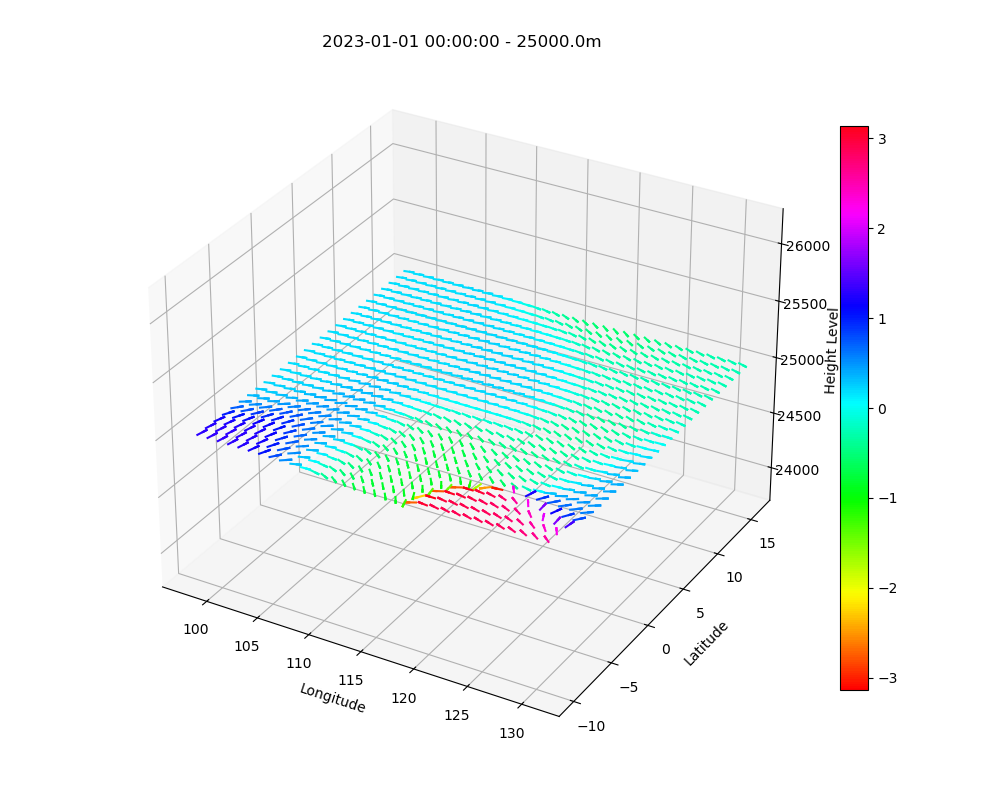

In [12]:
altitude = 25000
#synth_df2['longitude'] = synth_df2['longitude'].values[::-1]
#print(synth_df2['longitude'])
#print(synth_df2['latitude'][::-1])
plot_layer(synth_df2, 'xy', altitude*9.81)

In [ ]:
plot_level_original(df2, synth_df2['height'][20]/9.81)

In [ ]:
plot_level_original(df,  synth_df['height'][20]/9.81)

## Generate Simulated NETCDF

In [13]:
def convertToNETCDF(synth_df):

    #reverse longitude
    #synth_df['longitude'] = synth_df['longitude'].values[::-1]

    alt = synth_df['height'].values#[::-1]
    u_wind = synth_df['u_wind'].values
    v_wind = synth_df['v_wind'].values
    lat = synth_df['latitude'].values
    lon = synth_df['longitude'].values#[::-1] #for Some reason this needs to be reversed for Xarray?
    level = synth_df['pressure'].values#[::-1]
    time = synth_df['timestep'].values
    
    dims = [len(np.unique(lat)), len(np.unique(lon)), len(np.unique(level)), len(np.unique(time))]
    
    lat_dim = len(np.unique(lat))
    lon_dim = len(np.unique(lon))
    level_dim = len(np.unique(level))
    time_dim = len(np.unique(time))
    
    print("dims", lat_dim, lon_dim, level_dim, time_dim)
    
    alt_split = alt.reshape((time_dim, lat_dim, lon_dim, level_dim))
    u_wind_split = u_wind.reshape((time_dim, lat_dim, lon_dim, level_dim))
    v_wind_split = v_wind.reshape((time_dim, lat_dim, lon_dim, level_dim))
    
    print(alt_split.shape)
    print(np.transpose(alt_split, (0, 3, 1, 2)).shape)
    
    ds = xr.Dataset(
        data_vars = {
            'z' : (['time','level','latitude','longitude'], np.transpose(alt_split,(0, 3, 1, 2))),
            'u' : (['time','level','latitude','longitude'], np.transpose(u_wind_split, (0, 3, 1, 2))),
            'v' : (['time','level','latitude','longitude'], np.transpose(v_wind_split, (0, 3, 1, 2))),
        },
    
        coords={
            'time' : np.unique(time),
            'level' : np.unique(level),
            'latitude' : np.unique(lat)[::-1],
            'longitude' : np.unique(lon),
            
        },
    
        attrs={
            'Conventions': 'CF-1.6'
        }
    )

    #Reverse Longitude to match ERA5
    ds = ds.reindex(longitude=ds.longitude[::-1])
    ds['longitude'] = ds['longitude'].reindex(longitude=list(reversed(ds.longitude)))
    
    return ds

In [14]:
ds = convertToNETCDF(synth_df2)
ds.to_netcdf(r'/home/schuler/FLOW2D/forecasts/SynthCast.nc')
ds

dims 27 34 53 1
(1, 27, 34, 53)
(1, 53, 27, 34)


<xarray.Dataset>
Dimensions:    (longitude: 34, time: 1, level: 53, latitude: 27)
Coordinates:
  * longitude  (longitude) int64 98 99 100 101 102 103 ... 127 128 129 130 131
  * time       (time) datetime64[ns] 2023-01-01
  * level      (level) float64 16.16 16.78 17.43 18.1 ... 112.0 116.5 121.1
  * latitude   (latitude) object 16 15 14 13 12 11 10 ... -4 -5 -6 -7 -8 -9 -10
Data variables:
    z          (time, level, latitude, longitude) float64 2.747e+05 ... 1.472...
    u          (time, level, latitude, longitude) float64 -6.197 ... -34.54
    v          (time, level, latitude, longitude) float64 -8.85 -8.85 ... 11.89
Attributes:
    Conventions:  CF-1.6

## Visualize Synth Winds

In [26]:
ds = None
ds = xr.open_dataset(r'/home/schuler/FLOW2D/forecasts/SynthCast.nc')

In [27]:
%%capture
from era5.forecast import Forecast, Forecast_Subset
from era5.forecast_visualizer import ForecastVisualizer

filename = "../../forecasts/SynthCast.nc"
FORECAST_PRIMARY = Forecast(filename)

In [30]:
forecast_subset = Forecast_Subset(FORECAST_PRIMARY)
forecast_subset.assign_coord(0.5*(forecast_subset.Forecast.LAT_MAX + forecast_subset.Forecast.LAT_MIN),
                              0.5*(forecast_subset.Forecast.LON_MAX + forecast_subset.Forecast.LON_MIN),
                                "2023-01-01T00:00:00.000000000")
forecast_subset.subset_forecast()

forecast_subset.ds = forecast_subset.ds.isel(level = slice(10,11))

#Heights for Comparing
print(forecast_subset.ds.z.values[0,0,0,:]/9.81)

avg_alt = np.average(forecast_subset.ds.z.values[0,0,0,:]/9.81)
print(avg_alt)
#Round to nearest 250
avg_alt = int(avg_alt/ 250) * 250
print(avg_alt)

forecast_subset.ds

50000000
WHAT IS HAPPENING?
[24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000.
 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000.
 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000. 24000.
 24000. 24000. 24000. 24000.]
24000.0
24000


<xarray.Dataset>
Dimensions:    (latitude: 27, longitude: 34, time: 1, level: 1)
Coordinates:
  * latitude   (latitude) int64 -10 -9 -8 -7 -6 -5 -4 ... 10 11 12 13 14 15 16
  * longitude  (longitude) int64 98 99 100 101 102 103 ... 127 128 129 130 131
  * time       (time) datetime64[ns] 2023-01-01
  * level      (level) float64 29.72
Data variables:
    z          (time, level, latitude, longitude) float64 2.354e+05 ... 2.354...
    u          (time, level, latitude, longitude) float64 1.883 1.88 ... 11.11
    v          (time, level, latitude, longitude) float64 6.944 6.946 ... -6.412
Attributes:
    Conventions:  CF-1.6

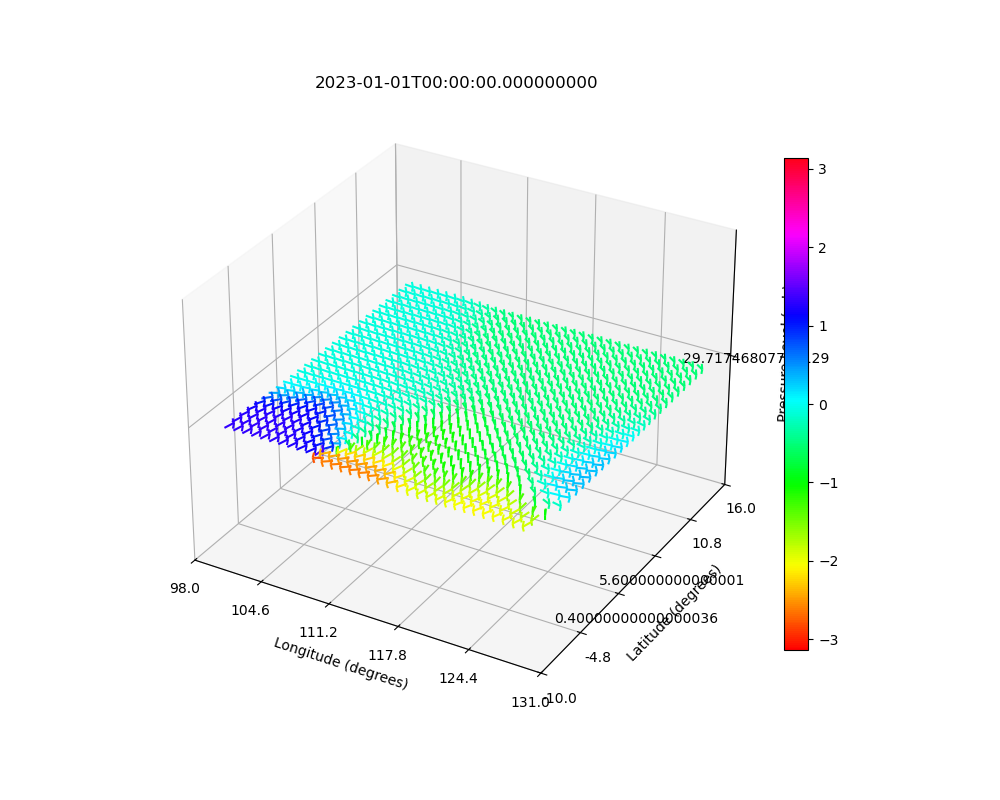

In [31]:
forecast_visualizer = ForecastVisualizer(forecast_subset)
forecast_visualizer.generate_flow_array(timestamp = forecast_subset.ds.time.values[0])

# Initialize Figure
fig = plt.figure(figsize=(10, 8))
#ax1 = fig.add_subplot(111, projection='3d')
ax1 = fig.add_subplot(111, projection='custom3dquiver')
# Manually add a CustomAxes3D to the figure
#ax1 = Custom3DQuiver(fig)
fig.add_axes(ax1)

skip = 1

#print("Saving Figure " + str(timestamp))
forecast_visualizer.visualize_3d_planar_flow(ax1, skip)
#plt.savefig(str(i) +'.png')
plt.show()

# ERA5 Forecast Visualization

In [32]:
from era5.forecast import Forecast, Forecast_Subset
from era5.forecast_visualizer import ForecastVisualizer

filename = "../../forecasts/Jan-2023-SEA.nc"
FORECAST_PRIMARY = Forecast(filename)
    

<xarray.Dataset>
Dimensions:    (latitude: 109, longitude: 161, level: 16, time: 744)
Coordinates:
  * latitude   (latitude) float32 -11.0 -10.75 -10.5 -10.25 ... 15.5 15.75 16.0
  * longitude  (longitude) float32 92.0 92.25 92.5 92.75 ... 131.5 131.8 132.0
  * level      (level) int32 7 10 20 30 50 70 100 ... 200 225 250 300 350 400
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-28 22:53:52 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
LAT RANGE: (109) -11.0, 16.0
LON RANGE: (161) 92.0, 132.0
PRES RANGE: (16) 7, 400
TIME RANGE: (744) 2023-01-01T00:00:00.000000000, 2023-01-31T23:00:00.000000000


In [34]:
forecast_subset = Forecast_Subset(FORECAST_PRIMARY)
forecast_subset.assign_coord(0.5*(forecast_subset.Forecast.LAT_MAX + forecast_subset.Forecast.LAT_MIN),
                              0.5*(forecast_subset.Forecast.LON_MAX + forecast_subset.Forecast.LON_MIN),
                                "2023-01-01T00:00:00.000000000")
forecast_subset.subset_forecast()

forecast_subset.ds = forecast_subset.ds.isel(level = slice(1,2))

#Heights for Comparing
print(forecast_subset.ds.z.values[0,0,0,:]/9.81)

avg_alt = np.average(forecast_subset.ds.z.values[0,0,0,:]/9.81)
print(avg_alt)
#Round to nearest 250
avg_alt = int(avg_alt/ 250) * 250
print(avg_alt)

forecast_subset.ds

50000000
WHAT IS HAPPENING?
[23764.838 23765.232 23765.232 23764.838 23764.838 23764.838 23764.838
 23765.232 23765.627 23766.021 23766.416 23766.81  23767.205 23767.602
 23767.994 23768.389 23768.389 23768.783 23769.178 23769.967 23770.363
 23771.15  23771.94  23772.729 23773.912 23774.701 23775.49  23776.28
 23776.674 23777.07  23777.07  23776.674 23776.28  23775.887 23775.49
 23775.096 23775.49  23775.887 23776.28  23777.463 23778.648 23780.225
 23781.803 23782.986 23784.172 23785.355 23786.143 23786.54  23787.326
 23787.723 23788.117 23788.906 23789.3   23790.088 23790.879 23792.062
 23793.246 23794.824 23796.402 23797.191 23797.191 23797.191 23797.191
 23797.191 23797.979 23798.375 23798.375 23798.375 23797.979 23797.586
 23797.586 23798.375 23799.559 23800.348 23800.74  23800.348 23799.559
 23799.164 23799.164 23799.953 23801.531 23803.11  23805.084 23806.266
 23807.45  23807.846 23807.846 23807.45  23807.055 23806.266 23805.477
 23805.084 23804.688 23804.293 23804.293 23804.293 

<xarray.Dataset>
Dimensions:    (latitude: 109, longitude: 161, level: 1, time: 25)
Coordinates:
  * latitude   (latitude) float32 -11.0 -10.75 -10.5 -10.25 ... 15.5 15.75 16.0
  * longitude  (longitude) float32 92.0 92.25 92.5 92.75 ... 131.5 131.8 132.0
  * level      (level) int32 30
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02
Data variables:
    z          (time, level, latitude, longitude) float32 2.331e+05 ... 2.33e+05
    t          (time, level, latitude, longitude) float32 215.1 215.1 ... 216.1
    u          (time, level, latitude, longitude) float32 -5.282 ... 3.727
    v          (time, level, latitude, longitude) float32 -2.494 ... 0.3312
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-28 22:53:52 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

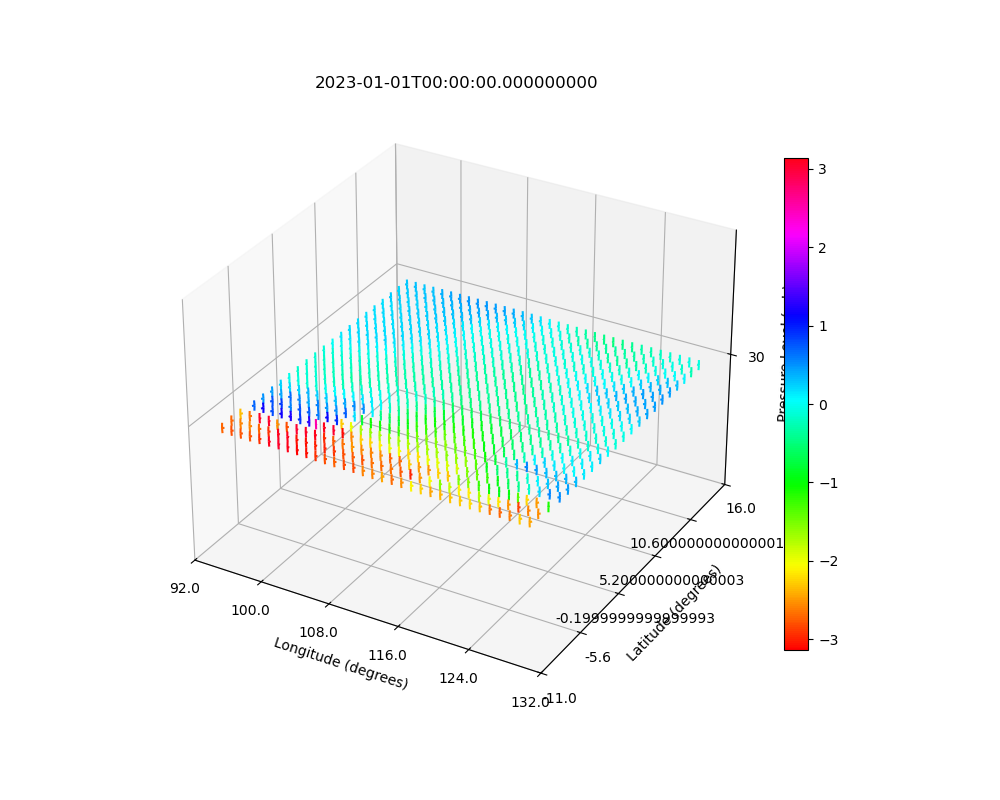

In [35]:
forecast_visualizer = ForecastVisualizer(forecast_subset)
forecast_visualizer.generate_flow_array(timestamp = forecast_subset.ds.time.values[0])

# Initialize Figure
fig = plt.figure(figsize=(10, 8))
#ax1 = fig.add_subplot(111, projection='3d')
ax1 = fig.add_subplot(111, projection='custom3dquiver')
# Manually add a CustomAxes3D to the figure
#ax1 = Custom3DQuiver(fig)
fig.add_axes(ax1)

skip = 5

#print("Saving Figure " + str(timestamp))
forecast_visualizer.visualize_3d_planar_flow(ax1, skip)
#plt.savefig(str(i) +'.png')
plt.show()

In [ ]:
%%capture

alts = []

slices = 6

for i in range (slices):
    #Reset Forecast Subset 

    forecast_subset.assign_coord(0.5*(forecast_subset.Forecast.LAT_MAX + forecast_subset.Forecast.LAT_MIN),
                              0.5*(forecast_subset.Forecast.LON_MAX + forecast_subset.Forecast.LON_MIN),
                                "2023-01-01T00:00:00.000000000");
    forecast_subset.subset_forecast();
    #Choose new slice
    forecast_subset.ds = forecast_subset.ds.isel(level = slice(i,i+1))

    #Regenerate Forecast Visualizer
    forecast_visualizer = ForecastVisualizer(forecast_subset);
    forecast_visualizer.generate_flow_array(timestamp = forecast_subset.ds.time.values[0]);


    #Get alt info for comparison
    avg_alt = np.average(forecast_subset.ds.z.values[0,0,0,:]/9.81)
    #Round to nearest 250
    avg_alt = int(avg_alt/ 250) * 250
    #Append
    alts.append(avg_alt)


    # Initialize Figure
    fig = plt.figure(figsize=(10, 8));
    #ax1 = fig.add_subplot(111, projection='3d')
    ax1 = fig.add_subplot(111, projection='custom3dquiver');
    # Manually add a CustomAxes3D to the figure
    #ax1 = Custom3DQuiver(fig)
    fig.add_axes(ax1);
    
    skip = 5
    
    #print("Saving Figure " + str(timestamp))
    forecast_visualizer.visualize_3d_planar_flow(ax1, skip);

    print("Saving Figure Level " + str(forecast_subset.ds.isel(level = 0)))
    plt.savefig(str(i) +'.png');

with imageio.get_writer('ERA5-Slices.gif', mode='I', duration=1000, loop=0) as writer:
    for i in range(slices):
        image = imageio.imread(str(i) +'.png')
        print(str(i) +'.png')
        writer.append_data(image)

    

In [ ]:
print(alts)
# Path to your GIF file
gif_path = 'ERA5-Slices.gif'
# Display the GIF
Image(filename=gif_path)

In [ ]:
%%capture
for i in range(0,len(alts)):
    altitude = alts[i]
    plot_layer(synth_df2, 'xy', altitude*9.81);

    plt.savefig("Radiosonde-" + str(i) +'.png')

with imageio.get_writer('Radiosonde-Slices.gif', mode='I', duration=1000, loop=0) as writer:
    for i in range(slices):
        image = imageio.imread("Radiosonde-" + str(i) +'.png')
        writer.append_data(image)

In [ ]:
# Path to your GIF file
gif_path = 'Radiosonde-Slices.gif'
# Display the GIF
Image(filename=gif_path)

# Create Bigger Synthetic Forecast

In [44]:
year = 2023
month = 1
day =1

ds_list = []

for d in range(day, 2+1):
    for h in [0,12]:

        # Aggregate Data
        base_dir = r"/mnt/d/RadioWinds/SOUNDINGS_DATA" 
        df2 = aggregate_data2(base_dir, 2023, 1, d, h)
        df2 = df2[(df2['longitude'] >= 90) & (df2['longitude'] <= 131.3) & (df2['latitude'] <= 18) &(df2['latitude'] >= -12.4)]
    
        #Synthesize Data
        df2 = df2[(df2['height'] >= 15000) & (df2['height'] <= 28000)] #Select desired altitude ranges
        
        lat_min, lat_max = -11, 16#int(df2['latitude'].min()), int(df2['latitude'].max())
        lon_min, lon_max = 92, 132 #int(df2['longitude'].min()), int(df2['longitude'].max())
        
        step = 1
        synth_df2 = create_synthetic_stations2(df2, lat_min, lat_max, lon_min, lon_max, step)
        
        #Format the SynthDF to match Xarray
        synth_df2 = format(synth_df2, df2)
        
        #Smooth Data
        lats, lons, alts = get_dims(synth_df2)
        synth_df2 = glob_smooth(synth_df2, lats, lons, alts)
    
        #Convert to Xarray
        ds = convertToNETCDF(synth_df2)
    
        #Add to ds list
        ds_list.append(ds)

# Concatenate the 12 hour interval synthetic radiosonde forecasts on the time dimension for an overall forecast
synthetic_forecast = xr.concat(ds_list, dim='time')

AGGREGATION... 
AGGREGATION : DONE.
SYNTHESIZING...
[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6
   7   8   9  10  11  12  13  14  15  16]
(41, 28)
(41, 28)
SYNTHESIS : DONE.
SMOOTHING...
SMOOTHING : DONE.
dims 28 41 53 1
(1, 28, 41, 53)
(1, 53, 28, 41)
AGGREGATION... 
AGGREGATION : DONE.
SYNTHESIZING...
[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6
   7   8   9  10  11  12  13  14  15  16]
(41, 28)
(41, 28)
SYNTHESIS : DONE.
SMOOTHING...
SMOOTHING : DONE.
dims 28 41 53 1
(1, 28, 41, 53)
(1, 53, 28, 41)
AGGREGATION... 
AGGREGATION : DONE.
SYNTHESIZING...
[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6
   7   8   9  10  11  12  13  14  15  16]
(41, 28)
(41, 28)
SYNTHESIS : DONE.
SMOOTHING...
SMOOTHING : DONE.
dims 28 41 53 1
(1, 28, 41, 53)
(1, 53, 28, 41)
AGGREGATION... 
AGGREGATION : DONE.
SYNTHESIZING...
[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6
   7   8   9  10  11  12  13 

/home/schuler/anaconda3/envs/FLOW2D/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [45]:
#Export to Netcdf
synthetic_forecast.to_netcdf(r'/home/schuler/FLOW2D/forecasts/SYNTH-Jan-2023-SEA.nc')
synthetic_forecast

<xarray.Dataset>
Dimensions:    (longitude: 41, time: 4, level: 53, latitude: 28)
Coordinates:
  * longitude  (longitude) int64 92 93 94 95 96 97 ... 127 128 129 130 131 132
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02T12:00:00
  * level      (level) float64 16.16 16.78 17.43 18.1 ... 112.0 116.5 121.1
  * latitude   (latitude) object 16 15 14 13 12 11 10 ... -5 -6 -7 -8 -9 -10 -11
Data variables:
    z          (time, level, latitude, longitude) float64 2.747e+05 ... 1.472...
    u          (time, level, latitude, longitude) float64 -6.197 ... -32.85
    v          (time, level, latitude, longitude) float64 -8.85 -8.85 ... 8.009
Attributes:
    Conventions:  CF-1.6